In [1]:
import os
import nibabel as nib
import numpy as np
import nibabel as nib
from nilearn import image, masking, plotting
from nilearn.decoding import SearchLight
from nilearn.input_data import NiftiMasker
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
import torch
import spacy
from tqdm import tqdm


c:\Users\lusim\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
"""Shared Response Model (SRM)

The implementations are based on the following publications:

.. [Chen2015] "A Reduced-Dimension fMRI Shared Response Model",
   P.-H. Chen, J. Chen, Y. Yeshurun-Dishon, U. Hasson, J. Haxby, P. Ramadge
   Advances in Neural Information Processing Systems (NIPS), 2015.
   http://papers.nips.cc/paper/5855-a-reduced-dimension-fmri-shared-response-model

.. [Anderson2016] "Enabling Factor Analysis on Thousand-Subject Neuroimaging
   Datasets",
   Michael J. Anderson, Mihai Capotă, Javier S. Turek, Xia Zhu, Theodore L.
   Willke, Yida Wang, Po-Hsuan Chen, Jeremy R. Manning, Peter J. Ramadge,
   Kenneth A. Norman,
   IEEE International Conference on Big Data, 2016.
   https://doi.org/10.1109/BigData.2016.7840719
"""

# Authors: Po-Hsuan Chen (Princeton Neuroscience Institute) and Javier Turek
# (Intel Labs), 2015

import logging

import numpy as np
import scipy
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import assert_all_finite
from sklearn.exceptions import NotFittedError
from mpi4py import MPI
import sys

__all__ = [
    "DetSRM",
    "SRM",
]

logger = logging.getLogger(__name__)


def _init_w_transforms(data, features, random_states, comm=MPI.COMM_SELF):
    """Initialize the mappings (Wi) for the SRM with random orthogonal
    matrices.

    Parameters
    ----------

    data : list of 2D arrays, element i has shape=[voxels_i, samples]
        Each element in the list contains the fMRI data of one subject.

    features : int
        The number of features in the model.

    random_states : list of `RandomState`s
        One `RandomState` instance per subject.

    comm : mpi4py.MPI.Intracomm
        The MPI communicator containing the data

    Returns
    -------

    w : list of array, element i has shape=[voxels_i, features]
        The initialized orthogonal transforms (mappings) :math:`W_i` for each
        subject.

    voxels : list of int
        A list with the number of voxels per subject.


    Note
    ----

        This function assumes that the numpy random number generator was
        initialized.

        Not thread safe.
    """
    w = []
    subjects = len(data)
    voxels = np.empty(subjects, dtype=int)

    # Set Wi to a random orthogonal voxels by features matrix
    for subject in range(subjects):
        if data[subject] is not None:
            voxels[subject] = data[subject].shape[0]
            rnd_matrix = random_states[subject].random_sample((
                voxels[subject], features))
            q, r = np.linalg.qr(rnd_matrix)
            w.append(q)
        else:
            voxels[subject] = 0
            w.append(None)
    voxels = comm.allreduce(voxels, op=MPI.SUM)
    return w, voxels


def load(file):
    """Load fitted SRM from .npz file.

    Parameters
    ----------

    file : str, file-like object, or pathlib.Path
        The .npz file to read containing fitted SRM saved using srm.save

    Returns
    --------

    srm : fitted SRM model
    """

    # Load file and extract SRM attributes
    loaded = np.load(file)
    w_ = [s for s in loaded['w_']]
    s_ = loaded['s_']
    sigma_s_ = loaded['sigma_s_']
    mu_ = [s for s in loaded['mu_']]
    rho2_ = loaded['rho2_']
    features, n_iter, rand_seed = loaded['kwargs']

    # Initialize new SRM object and attach loaded attributes
    srm = SRM(n_iter=n_iter, features=features, rand_seed=rand_seed)
    srm.w_ = w_
    srm.s_ = s_
    srm.sigma_s_ = sigma_s_
    srm.mu_ = mu_
    srm.rho2_ = rho2_

    return srm


class SRM(BaseEstimator, TransformerMixin):
    """Probabilistic Shared Response Model (SRM)

    Given multi-subject data, factorize it as a shared response S among all
    subjects and an orthogonal transform W per subject:

    .. math:: X_i \\approx W_i S, \\forall i=1 \\dots N

    Parameters
    ----------

    n_iter : int, default: 10
        Number of iterations to run the algorithm.

    features : int, default: 50
        Number of features to compute.

    rand_seed : int, default: 0
        Seed for initializing the random number generator.

    comm : mpi4py.MPI.Intracomm
        The MPI communicator containing the data

    Attributes
    ----------

    w_ : list of array, element i has shape=[voxels_i, features]
        The orthogonal transforms (mappings) for each subject.

    s_ : array, shape=[features, samples]
        The shared response.

    sigma_s_ : array, shape=[features, features]
        The covariance of the shared response Normal distribution.

    mu_ : list of array, element i has shape=[voxels_i]
        The voxel means over the samples for each subject.

    rho2_ : array, shape=[subjects]
        The estimated noise variance :math:`\\rho_i^2` for each subject

    comm : mpi4py.MPI.Intracomm
        The MPI communicator containing the data

    random_state_: `RandomState`
        Random number generator initialized using rand_seed

    Note
    ----

       The number of voxels may be different between subjects. However, the
       number of samples must be the same across subjects.

       The probabilistic Shared Response Model is approximated using the
       Expectation Maximization (EM) algorithm proposed in [Chen2015]_. The
       implementation follows the optimizations published in [Anderson2016]_.

       This is a single node version.

       The run-time complexity is :math:`O(I (V T K + V K^2 + K^3))` and the
       memory complexity is :math:`O(V T)` with I - the number of iterations,
       V - the sum of voxels from all subjects, T - the number of samples, and
       K - the number of features (typically, :math:`V \\gg T \\gg K`).
    """

    def __init__(self, n_iter=10, features=50, rand_seed=0,
                 comm=MPI.COMM_SELF):
        self.n_iter = n_iter
        self.features = features
        self.rand_seed = rand_seed
        self.comm = comm
        return

    def fit(self, X, y=None):
        """Compute the probabilistic Shared Response Model

        Parameters
        ----------
        X :  list of 2D arrays, element i has shape=[voxels_i, samples]
            Each element in the list contains the fMRI data of one subject.

        y : not used
        """
        logger.info('Starting Probabilistic SRM')

        # Check the number of subjects
        if len(X) <= 1:
            raise ValueError("There are not enough subjects "
                             "({0:d}) to train the model.".format(len(X)))

        # Check for input data sizes
        number_subjects = len(X)
        number_subjects_vec = self.comm.allgather(number_subjects)
        for rank in range(self.comm.Get_size()):
            if number_subjects_vec[rank] != number_subjects:
                raise ValueError(
                    "Not all ranks have same number of subjects")

        # Collect size information
        shape0 = np.zeros((number_subjects,), dtype=int)
        shape1 = np.zeros((number_subjects,), dtype=int)

        for subject in range(number_subjects):
            if X[subject] is not None:
                assert_all_finite(X[subject])
                shape0[subject] = X[subject].shape[0]
                shape1[subject] = X[subject].shape[1]

        shape0 = self.comm.allreduce(shape0, op=MPI.SUM)
        shape1 = self.comm.allreduce(shape1, op=MPI.SUM)

        # Check if all subjects have same number of TRs
        number_trs = np.min(shape1)
        for subject in range(number_subjects):
            if shape1[subject] < self.features:
                raise ValueError(
                    "There are not enough samples to train the model with "
                    "{0:d} features.".format(self.features))
            if shape1[subject] != number_trs:
                raise ValueError("Different number of samples between subjects"
                                 ".")
        # Run SRM
        self.sigma_s_, self.w_, self.mu_, self.rho2_, self.s_ = self._srm(X)

        return self

    def transform(self, X, y=None):
        """Use the model to transform matrix to Shared Response space

        Parameters
        ----------
        X : list of 2D arrays, element i has shape=[voxels_i, samples_i]
            Each element in the list contains the fMRI data of one subject
            note that number of voxels and samples can vary across subjects
        y : not used (as it is unsupervised learning)


        Returns
        -------
        s : list of 2D arrays, element i has shape=[features_i, samples_i]
            Shared responses from input data (X)
        """

        # Check if the model exist
        if hasattr(self, 'w_') is False:
            raise NotFittedError("The model fit has not been run yet.")

        # Check the number of subjects
        if len(X) != len(self.w_):
            raise ValueError("The number of subjects does not match the one"
                             " in the model.")

        s = [None] * len(X)
        for subject in range(len(X)):
            if X[subject] is not None:
                s[subject] = self.w_[subject].T.dot(X[subject])

        return s

    def _init_structures(self, data, subjects):
        """Initializes data structures for SRM and preprocess the data.


        Parameters
        ----------
        data : list of 2D arrays, element i has shape=[voxels_i, samples]
            Each element in the list contains the fMRI data of one subject.

        subjects : int
            The total number of subjects in `data`.


        Returns
        -------
        x : list of array, element i has shape=[voxels_i, samples]
            Demeaned data for each subject.

        mu : list of array, element i has shape=[voxels_i]
            Voxel means over samples, per subject.

        rho2 : array, shape=[subjects]
            Noise variance :math:`\\rho^2` per subject.

        trace_xtx : array, shape=[subjects]
            The squared Frobenius norm of the demeaned data in `x`.
        """
        x = []
        mu = []
        rho2 = np.zeros(subjects)

        trace_xtx = np.zeros(subjects)

        for subject in range(subjects):
            rho2[subject] = 1
            if data[subject] is not None:
                mu.append(np.mean(data[subject], 1))
                trace_xtx[subject] = np.sum(data[subject] ** 2)
                x.append(data[subject] - mu[subject][:, np.newaxis])
            else:
                mu.append(None)
                trace_xtx[subject] = 0
                x.append(None)

        return x, mu, rho2, trace_xtx

    def _likelihood(self, chol_sigma_s_rhos, log_det_psi, chol_sigma_s,
                    trace_xt_invsigma2_x, inv_sigma_s_rhos, wt_invpsi_x,
                    samples):
        """Calculate the log-likelihood function


        Parameters
        ----------

        chol_sigma_s_rhos : array, shape=[features, features]
            Cholesky factorization of the matrix (Sigma_S + sum_i(1/rho_i^2)
            * I)

        log_det_psi : float
            Determinant of diagonal matrix Psi (containing the rho_i^2 value
            voxels_i times).

        chol_sigma_s : array, shape=[features, features]
            Cholesky factorization of the matrix Sigma_S

        trace_xt_invsigma2_x : float
            Trace of :math:`\\sum_i (||X_i||_F^2/\\rho_i^2)`

        inv_sigma_s_rhos : array, shape=[features, features]
            Inverse of :math:`(\\Sigma_S + \\sum_i(1/\\rho_i^2) * I)`

        wt_invpsi_x : array, shape=[features, samples]

        samples : int
            The total number of samples in the data.


        Returns
        -------

        loglikehood : float
            The log-likelihood value.
        """
        log_det = (np.log(np.diag(chol_sigma_s_rhos) ** 2).sum() + log_det_psi
                   + np.log(np.diag(chol_sigma_s) ** 2).sum())
        loglikehood = -0.5 * samples * log_det - 0.5 * trace_xt_invsigma2_x
        loglikehood += 0.5 * np.trace(
            wt_invpsi_x.T.dot(inv_sigma_s_rhos).dot(wt_invpsi_x))
        # + const --> -0.5*nTR*nvoxel*subjects*math.log(2*math.pi)

        return loglikehood

    @staticmethod
    def _update_transform_subject(Xi, S):
        """Updates the mappings `W_i` for one subject.

        Parameters
        ----------

        Xi : array, shape=[voxels, timepoints]
            The fMRI data :math:`X_i` for aligning the subject.

        S : array, shape=[features, timepoints]
            The shared response.

        Returns
        -------

        Wi : array, shape=[voxels, features]
            The orthogonal transform (mapping) :math:`W_i` for the subject.
        """
        A = Xi.dot(S.T)
        # Solve the Procrustes problem
        U, _, V = np.linalg.svd(A, full_matrices=False)
        return U.dot(V)

    def transform_subject(self, X):
        """Transform a new subject using the existing model.
        The subject is assumed to have recieved equivalent stimulation

        Parameters
        ----------

        X : 2D array, shape=[voxels, timepoints]
            The fMRI data of the new subject.

        Returns
        -------

        w : 2D array, shape=[voxels, features]
            Orthogonal mapping `W_{new}` for new subject

        """
        # Check if the model exist
        if hasattr(self, 'w_') is False:
            raise NotFittedError("The model fit has not been run yet.")

        # Check the number of TRs in the subject
        if X.shape[1] != self.s_.shape[1]:
            raise ValueError("The number of timepoints(TRs) does not match the"
                             "one in the model.")

        w = self._update_transform_subject(X, self.s_)

        return w

    def save(self, file):
        """Save fitted SRM to .npz file.

        Parameters
        ----------

        file : str, file-like object, or pathlib.Path
            Filename (string), open file (file-like object) or pathlib.Path
            where the fitted SRM will be saved. If file is a string or a Path,
            the .npz extension will be appended to the filename if it is not
            already there.

        Returns
        -------

        None
        """

        # Check if the model has been estimated
        if hasattr(self, 'w_') is False:
            raise NotFittedError("The model fit has not been run yet.")

        np.savez_compressed(
            file,
            w_=self.w_,
            s_=self.s_,
            sigma_s_=self.sigma_s_,
            mu_=self.mu_,
            rho2_=self.rho2_,
            kwargs=np.array([self.features, self.n_iter, self.rand_seed])
        )

    def _srm(self, data):
        """Expectation-Maximization algorithm for fitting the probabilistic
        SRM.

        Parameters
        ----------

        data : list of 2D arrays, element i has shape=[voxels_i, samples]
            Each element in the list contains the fMRI data of one subject.


        Returns
        -------

        sigma_s : array, shape=[features, features]
            The covariance :math:`\\Sigma_s` of the shared response Normal
            distribution.

        w : list of array, element i has shape=[voxels_i, features]
            The orthogonal transforms (mappings) :math:`W_i` for each subject.

        mu : list of array, element i has shape=[voxels_i]
            The voxel means :math:`\\mu_i` over the samples for each subject.

        rho2 : array, shape=[subjects]
            The estimated noise variance :math:`\\rho_i^2` for each subject

        s : array, shape=[features, samples]
            The shared response.
        """

        local_min = min([d.shape[1] for d in data if d is not None],
                        default=sys.maxsize)
        samples = self.comm.allreduce(local_min, op=MPI.MIN)
        subjects = len(data)
        self.random_state_ = np.random.RandomState(self.rand_seed)
        random_states = [
            np.random.RandomState(self.random_state_.randint(2 ** 32))
            for i in range(len(data))]

        # Initialization step: initialize the outputs with initial values,
        # voxels with the number of voxels in each subject, and trace_xtx with
        # the ||X_i||_F^2 of each subject.
        w, voxels = _init_w_transforms(data, self.features, random_states,
                                       self.comm)
        x, mu, rho2, trace_xtx = self._init_structures(data, subjects)
        shared_response = np.zeros((self.features, samples))
        sigma_s = np.identity(self.features)

        rank = self.comm.Get_rank()

        # Main loop of the algorithm (run
        for iteration in range(self.n_iter):
            logger.info('Iteration %d' % (iteration + 1))

            # E-step:

            # Sum the inverted the rho2 elements for computing W^T * Psi^-1 * W
            if rank == 0:
                rho0 = (1 / rho2).sum()

                # Invert Sigma_s using Cholesky factorization
                (chol_sigma_s, lower_sigma_s) = scipy.linalg.cho_factor(
                    sigma_s, check_finite=False)
                inv_sigma_s = scipy.linalg.cho_solve(
                    (chol_sigma_s, lower_sigma_s), np.identity(self.features),
                    check_finite=False)

                # Invert (Sigma_s + rho_0 * I) using Cholesky factorization
                sigma_s_rhos = inv_sigma_s + np.identity(self.features) * rho0
                chol_sigma_s_rhos, lower_sigma_s_rhos = \
                    scipy.linalg.cho_factor(sigma_s_rhos,
                                            check_finite=False)
                inv_sigma_s_rhos = scipy.linalg.cho_solve(
                    (chol_sigma_s_rhos, lower_sigma_s_rhos),
                    np.identity(self.features), check_finite=False)

            # Compute the sum of W_i^T * rho_i^-2 * X_i, and the sum of traces
            # of X_i^T * rho_i^-2 * X_i
            wt_invpsi_x = np.zeros((self.features, samples))
            trace_xt_invsigma2_x = 0.0
            for subject in range(subjects):
                if data[subject] is not None:
                    wt_invpsi_x += (w[subject].T.dot(x[subject])) \
                                   / rho2[subject]
                    trace_xt_invsigma2_x += trace_xtx[subject] / rho2[subject]

            wt_invpsi_x = self.comm.reduce(wt_invpsi_x, op=MPI.SUM)
            trace_xt_invsigma2_x = self.comm.reduce(trace_xt_invsigma2_x,
                                                    op=MPI.SUM)
            trace_sigma_s = None
            if rank == 0:
                log_det_psi = np.sum(np.log(rho2) * voxels)

                # Update the shared response
                shared_response = sigma_s.dot(
                    np.identity(self.features) - rho0 * inv_sigma_s_rhos).dot(
                    wt_invpsi_x)

                # M-step

                # Update Sigma_s and compute its trace
                sigma_s = (inv_sigma_s_rhos
                           + shared_response.dot(shared_response.T) / samples)
                trace_sigma_s = samples * np.trace(sigma_s)

            shared_response = self.comm.bcast(shared_response)
            trace_sigma_s = self.comm.bcast(trace_sigma_s)

            # Update each subject's mapping transform W_i and error variance
            # rho_i^2
            for subject in range(subjects):
                if x[subject] is not None:
                    a_subject = x[subject].dot(shared_response.T)
                    perturbation = np.zeros(a_subject.shape)
                    np.fill_diagonal(perturbation, 0.001)
                    u_subject, s_subject, v_subject = np.linalg.svd(
                        a_subject + perturbation, full_matrices=False)
                    w[subject] = u_subject.dot(v_subject)
                    rho2[subject] = trace_xtx[subject]
                    rho2[subject] += -2 * np.sum(w[subject] * a_subject).sum()
                    rho2[subject] += trace_sigma_s
                    rho2[subject] /= samples * voxels[subject]
                else:
                    rho2[subject] = 0

            rho2 = self.comm.allreduce(rho2, op=MPI.SUM)

            if rank == 0:
                if logger.isEnabledFor(logging.INFO):
                    # Calculate and log the current log-likelihood for checking
                    # convergence
                    loglike = self._likelihood(
                        chol_sigma_s_rhos, log_det_psi, chol_sigma_s,
                        trace_xt_invsigma2_x, inv_sigma_s_rhos, wt_invpsi_x,
                        samples)
                    logger.info('Objective function %f' % loglike)

        sigma_s = self.comm.bcast(sigma_s)
        return sigma_s, w, mu, rho2, shared_response


class DetSRM(BaseEstimator, TransformerMixin):
    """Deterministic Shared Response Model (DetSRM)

    Given multi-subject data, factorize it as a shared response S among all
    subjects and an orthogonal transform W per subject:

    .. math:: X_i \\approx W_i S, \\forall i=1 \\dots N

    Parameters
    ----------

    n_iter : int, default: 10
        Number of iterations to run the algorithm.

    features : int, default: 50
        Number of features to compute.

    rand_seed : int, default: 0
        Seed for initializing the random number generator.


    Attributes
    ----------

    w_ : list of array, element i has shape=[voxels_i, features]
        The orthogonal transforms (mappings) for each subject.

    s_ : array, shape=[features, samples]
        The shared response.

    random_state_: `RandomState`
        Random number generator initialized using rand_seed

    Note
    ----

        The number of voxels may be different between subjects. However, the
        number of samples must be the same across subjects.

        The Deterministic Shared Response Model is approximated using the
        Block Coordinate Descent (BCD) algorithm proposed in [Chen2015]_.

        This is a single node version.

        The run-time complexity is :math:`O(I (V T K + V K^2))` and the memory
        complexity is :math:`O(V T)` with I - the number of iterations, V - the
        sum of voxels from all subjects, T - the number of samples, K - the
        number of features (typically, :math:`V \\gg T \\gg K`), and N - the
        number of subjects.
    """

    def __init__(self, n_iter=10, features=50, rand_seed=0):
        self.n_iter = n_iter
        self.features = features
        self.rand_seed = rand_seed
        return

    def fit(self, X, y=None):
        """Compute the Deterministic Shared Response Model

        Parameters
        ----------
        X : list of 2D arrays, element i has shape=[voxels_i, samples]
            Each element in the list contains the fMRI data of one subject.

        y : not used
        """
        logger.info('Starting Deterministic SRM')

        # Check the number of subjects
        if len(X) <= 1:
            raise ValueError("There are not enough subjects "
                             "({0:d}) to train the model.".format(len(X)))

        # Check for input data sizes
        if X[0].shape[1] < self.features:
            raise ValueError(
                "There are not enough samples to train the model with "
                "{0:d} features.".format(self.features))

        # Check if all subjects have same number of TRs
        number_trs = X[0].shape[1]
        number_subjects = len(X)
        for subject in range(number_subjects):
            assert_all_finite(X[subject])
            if X[subject].shape[1] != number_trs:
                raise ValueError("Different number of samples between subjects"
                                 ".")

        # Run SRM
        self.w_, self.s_ = self._srm(X)

        return self

    def transform(self, X, y=None):
        """Use the model to transform data to the Shared Response subspace

        Parameters
        ----------
        X : list of 2D arrays, element i has shape=[voxels_i, samples_i]
            Each element in the list contains the fMRI data of one subject.

        y : not used


        Returns
        -------
        s : list of 2D arrays, element i has shape=[features_i, samples_i]
            Shared responses from input data (X)
        """

        # Check if the model exist
        if hasattr(self, 'w_') is False:
            raise NotFittedError("The model fit has not been run yet.")

        # Check the number of subjects
        if len(X) != len(self.w_):
            raise ValueError("The number of subjects does not match the one"
                             " in the model.")

        s = [None] * len(X)
        for subject in range(len(X)):
            s[subject] = self.w_[subject].T.dot(X[subject])

        return s

    def _objective_function(self, data, w, s):
        """Calculate the objective function

        Parameters
        ----------

        data : list of 2D arrays, element i has shape=[voxels_i, samples]
            Each element in the list contains the fMRI data of one subject.

        w : list of 2D arrays, element i has shape=[voxels_i, features]
            The orthogonal transforms (mappings) :math:`W_i` for each subject.

        s : array, shape=[features, samples]
            The shared response

        Returns
        -------

        objective : float
            The objective function value.
        """
        subjects = len(data)
        objective = 0.0
        for m in range(subjects):
            objective += \
                np.linalg.norm(data[m] - w[m].dot(s), 'fro') ** 2

        return objective * 0.5 / data[0].shape[1]

    def _compute_shared_response(self, data, w):
        """ Compute the shared response S

        Parameters
        ----------

        data : list of 2D arrays, element i has shape=[voxels_i, samples]
            Each element in the list contains the fMRI data of one subject.

        w : list of 2D arrays, element i has shape=[voxels_i, features]
            The orthogonal transforms (mappings) :math:`W_i` for each subject.

        Returns
        -------

        s : array, shape=[features, samples]
            The shared response for the subjects data with the mappings in w.
        """
        s = np.zeros((w[0].shape[1], data[0].shape[1]))
        for m in range(len(w)):
            s = s + w[m].T.dot(data[m])
        s /= len(w)

        return s

    @staticmethod
    def _update_transform_subject(Xi, S):
        """Updates the mappings `W_i` for one subject.

        Parameters
        ----------

        Xi : array, shape=[voxels, timepoints]
            The fMRI data :math:`X_i` for aligning the subject.

        S : array, shape=[features, timepoints]
            The shared response.

        Returns
        -------

        Wi : array, shape=[voxels, features]
            The orthogonal transform (mapping) :math:`W_i` for the subject.
        """
        A = Xi.dot(S.T)
        # Solve the Procrustes problem
        U, _, V = np.linalg.svd(A, full_matrices=False)
        return U.dot(V)

    def transform_subject(self, X):
        """Transform a new subject using the existing model.
        The subject is assumed to have recieved equivalent stimulation

        Parameters
        ----------

        X : 2D array, shape=[voxels, timepoints]
            The fMRI data of the new subject.

        Returns
        -------

        w : 2D array, shape=[voxels, features]
            Orthogonal mapping `W_{new}` for new subject
        """
        # Check if the model exist
        if hasattr(self, 'w_') is False:
            raise NotFittedError("The model fit has not been run yet.")

        # Check the number of TRs in the subject
        if X.shape[1] != self.s_.shape[1]:
            raise ValueError("The number of timepoints(TRs) does not match the"
                             "one in the model.")

        w = self._update_transform_subject(X, self.s_)

        return w

    def _srm(self, data):
        """Expectation-Maximization algorithm for fitting the probabilistic
        SRM.

        Parameters
        ----------

        data : list of 2D arrays, element i has shape=[voxels_i, samples]
            Each element in the list contains the fMRI data of one subject.


        Returns
        -------

        w : list of array, element i has shape=[voxels_i, features]
            The orthogonal transforms (mappings) :math:`W_i` for each subject.

        s : array, shape=[features, samples]
            The shared response.
        """

        subjects = len(data)

        self.random_state_ = np.random.RandomState(self.rand_seed)
        random_states = [
            np.random.RandomState(self.random_state_.randint(2 ** 32))
            for i in range(len(data))]

        # Initialization step: initialize the outputs with initial values,
        # voxels with the number of voxels in each subject.
        w, _ = _init_w_transforms(data, self.features, random_states)
        shared_response = self._compute_shared_response(data, w)
        if logger.isEnabledFor(logging.INFO):
            # Calculate the current objective function value
            objective = self._objective_function(data, w, shared_response)
            logger.info('Objective function %f' % objective)

        # Main loop of the algorithm
        for iteration in range(self.n_iter):
            logger.info('Iteration %d' % (iteration + 1))

            # Update each subject's mapping transform W_i:
            for subject in range(subjects):
                a_subject = data[subject].dot(shared_response.T)
                perturbation = np.zeros(a_subject.shape)
                np.fill_diagonal(perturbation, 0.001)
                u_subject, _, v_subject = np.linalg.svd(
                    a_subject + perturbation, full_matrices=False)
                w[subject] = u_subject.dot(v_subject)

            # Update the shared response:
            shared_response = self._compute_shared_response(data, w)

            if logger.isEnabledFor(logging.INFO):
                # Calculate the current objective function value
                objective = self._objective_function(data, w, shared_response)
                logger.info('Objective function %f' % objective)

        return w, shared_response


In [2]:
# carga de archivos fmri
data_dir = 'C:/Users/lusim/OneDrive/Desktop/neurocomp/ds000113'
mask_dir = "C:/Users/lusim/OneDrive/Desktop/neurocomp/3mm_mask.nii.gz"

fnames_data = [ f'{data_dir}/sub-01/ses-movie/func/sub-01_ses-movie_task-movie_run-{i}_bold.nii.gz' for i in range(1,9)]

fmri_imgs = []
fmri_data = []

for f in fnames_data:
    img = nib.load(f)
    data = img.get_fdata()
    
    fmri_imgs.append(img)
    fmri_data.append(data)
    
mask_img = nib.load(mask_dir)
mask_data = mask_img.get_fdata()
    
print('fMRI data succesfully loaded')
print(f'Mask shape: {mask_img.shape}')

fMRI data succesfully loaded
Mask shape: (61, 73, 61)


In [3]:
print('fMRI shapes:')
for array in fmri_data:
    print(array.shape)

fMRI shapes:
(80, 80, 35, 451)
(80, 80, 35, 441)
(80, 80, 35, 438)
(80, 80, 35, 488)
(80, 80, 35, 462)
(80, 80, 35, 439)
(80, 80, 35, 542)
(80, 80, 35, 338)


In [7]:
data = np.concatenate((fmri_data), axis = 3)

affine = nib.load(fnames_data[0]).affine
img = nib.Nifti1Image(data, affine) # Create a new NiBabel image

print(data.shape)

(80, 80, 35, 3599)


In [5]:
# csv with annotations
dialogue_file = "C:/Users/lusim/OneDrive/Desktop/neurocomp/ds000113/stimuli/annotations/german_audio_description.csv"
text_data = pd.read_csv(dialogue_file, header=None)
text_data.columns = ['start', 'end', 'text']
texts = text_data['text']
text_data.head()

,start,end,text
0,1.3,10.5,Eine Computeranimation: Auf einen schroffen Be...
1,15.9,19.5,Vor bewölktem Himmel schwebt eine grau-weiße F...
2,22.6,25.8,In einer Stadt segelt sie über die Baumkronen ...
3,31.7,36.7,Ein Robert-Zemeckis-Film: Tom Hanks als 'FORRE...
4,40.7,61.0,Die Feder fliegt ein paar Meter über den Wipfe...


In [6]:
# nlp model deutsch
nlp = spacy.load('de_core_news_sm')
embeddings = []

for _, row in tqdm(text_data.iterrows(), total = text_data.shape[0]):
    doc = nlp(row['text'])
    embeddings.append(doc.vector)
    
embeddings = np.array(embeddings)
   
# TR = 2s (tiempo de adquisicion) y 3599 muestras temporales.
TS = 2

100%|██████████| 573/573 [00:03<00:00, 162.88it/s]


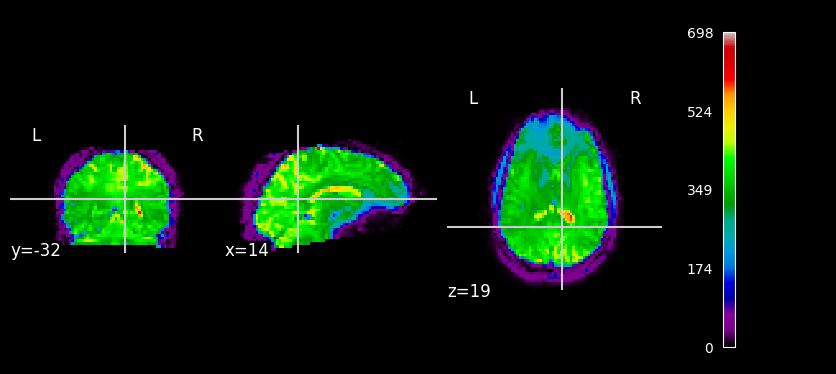

In [9]:
time_point = 34
slice_index = data.shape[2] // 2
slice_data = data[:,:, slice_index, time_point]

volume_img = nib.Nifti1Image(img.slicer[..., time_point].get_fdata(), img.affine)

# Plot the image
plotting.plot_epi(volume_img, colorbar=True, cbar_tick_format="%i")
plt.title(f'Slice {slice_index}, time frame {time_point}')
plt.show()

In [42]:
# juani no se esto revisalo

aligned_embeddings = np.zeros(img.shape[-1], dtype = object)

for i, row in text_data.iterrows():
    
    start_frame = int(row['start'] // TS)
    end_frame = int(row['end'] // TS + 1) # +1 to include the end_frame
    embed = embeddings[i]
    
    for frame in range(start_frame, end_frame + 1):
        aligned_embeddings[frame] = embed
    

In [48]:
# me estan quedando muchos elementos en 0. los quiero llenar con el next non-zero element
print(aligned_embeddings[-30:])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [22]:
pca = PCA(n_components = 100) 

masker = masking.compute_epi_mask(img)
masked_data = masking.apply_mask(img, masker)
reduced_fmri = pca.fit_transform(masked_data)

In [23]:
reduced_fmri.shape

(3599, 100)

In [24]:
# ajusto el modelo lineal
reg = LinearRegression()
reg.fit(reduced_fmri, aligned_embeddings)
prediction = reg.predict(reduced_fmri)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [37]:
# calculo similitud entre 
# vectores de texto y las predicciones para cada sujeto
from sklearn.metrics.pairwise import cosine_similarity

thresh = 0.8

similarity = cosine_similarity(prediction, aligned_embeddings)
correct_predictions = np.sum(np.diag(similarity) >= thresh)
total_predictions = similarity.shape[0]
accuracy = correct_predictions / total_predictions * 100

In [38]:
print(accuracy)

23.31203111975549


### Anatomical searchlight

In [10]:
from nilearn.decoding import SearchLight
from sklearn.svm import SVC
from sklearn.model_selection import KFold

svc = SVC(kernel='linear')
searchlight = SearchLight(mask_img, process_mask_img= mask_img,
                          radius = 5.6,
                          estimator = svc,
                          cv = KFold(n_splits = 5),
                          verbose = 1)

searchlight.fit()